<a href="https://colab.research.google.com/github/yi-ye-zhi-qiu/metis-project4/blob/main/poemgenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import stuff

# NOTE: gutenberg MUST be run in a separate notebook, collab cannot handle gutenberg's necessary python 2.7 dependencies, unlike Jupyter
# ^^ for more, see: https://pypi.org/project/Gutenberg/  we cannot run the requisite "brew install berkeley-db4" command 


#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#SKLearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF



#Other
# from gutenberg.acquire import load_etext
# from gutenberg.cleanup import strip_headers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import re

In [3]:
#gutenberg is used to fetch book txt files, so long as we give it the book ID
#we will, in addition to that, feed in the # of lines we want to skip (think of it like skipping the first 10 pages),
#and give it a personal name

books = [
#   BookID, skip N lines
#   (26715, 1000, 'Victorian songs'),
#   (30235, 580, 'Baldwin collection'),
#   (35402, 710, 'Swinburne collection'),
#   (574, 15, 'Blake'),
#   (1304, 172, 'Bulchevys collection'),
#   (19221, 223, 'Palgrave-Pearse collection'),
#   (15553, 522, 'Knowles collection') ,
    (17650, 6605, 'The Sonnets, Triumphs, and Other Poems of Petrarch by Francesco Petrarca') 
#                                    Link: https://www.gutenberg.org/ebooks/17650
#                                    6605 is the # of lines that we skip to get 
#                                    to the poems.
]

# Get cleaned text file

In [ ]:
#Save as raw.txt file
with open('data/poetry/raw.txt', 'w') as ofp:
  lineno = 0
  for (id_nr, toskip, title) in books:
    startline = lineno
    text = strip_headers(load_etext(id_nr, mirror='http://mirrors.xmission.com/gutenberg/')).strip()
    lines = text.split('\n')[toskip:]
    for line in lines:
      if (len(line) > 0 
          and line.upper() != line 
          and not re.match('.*[0-9]+.*', line)
          and len(line) < 50
         ): #skip Titles
        cleaned = re.sub('[^a-z\'\-]+', ' ', line.strip().lower()) #all lowercase, only letters
        ofp.write(cleaned)
        ofp.write('\n')
        lineno = lineno + 1 #next line
      else:
        ofp.write('\n')
    print('Wrote lines {} to {} from {}'.format(startline, lineno, title))

In [5]:
#Connect to Google drive, where raw.txt is stored. 
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
#Now that we are connected to our gDrive, we can read in raw.txt
raw = pd.read_csv('/content/drive/My Drive/notebooks/raw.txt')
raw = raw.values.tolist()

print("Example data structure, note that it is a list of lists: \n",raw[0:2])

Example data structure, note that it is a list of lists: 
 [['of those sad sighs with which my heart i fed'], ['when early youth my mazy wanderings led ']]


# LDA/NMF

In [98]:
#Define corpus as just one long list as opposed to list of lists?
corpus = [','.join(x) for x in raw]

In [90]:
#Instantiate count vectorizer
CV = CountVectorizer(ngram_range=(1, 1), stop_words='english')

#Fit to data
Vector = CV.fit_transform(corpus)

#LDA
lda = LatentDirichletAllocation(n_components=5)
lda_Fit = lda.fit_transform(Vector)

#NMF
#Look @ top 10 words, name as clusters - ask the user to pick one of those
nmf = NMF(n_components=100, init='random', random_state=0)
nmf_Fit = nmf.fit_transform(Vector)
nmf_Components = nmf.components_

print(Vector.shape[0],'poems analyzed by CountVectorizer')
print(nmf_Components.shape[1], 'poems analyzed by NMF')
print(len(lda_Fit),'poems analyzed by LDA')

10982 poems analyzed by CountVectorizer
8217 poems analyzed by NMF
10982 poems analyzed by LDA


In [91]:
#df is FIT ON NMF
#df = pd.DataFrame(data = Vector.toarray(), columns=CV.get_feature_names())
#df = pd.DataFrame(data = nmf_Components, columns=CV.get_feature_names())

## Analyze NMF/LDA (top 10 topics)

In [12]:
features = CV.get_feature_names()

#Words from NMF
a = nmf_Components.argsort(axis=1)[:,-1:-7:-1]
nmf_words = [[features[e] for e in l] for l in a]
print('NMF poem topic words \n', nmf_words)

#Words from LDA
b = lda.components_.argsort(axis=1)[:,-1:-7:-1]
lda_words = [[corpus[e] for e in l] for l in b]
print('LDA poem topic words \n', lda_words)

NMF poem topic words 
 [['love', 'long', 'cruel', 'death', 'fortune', 'mind'], ['heart', 'thy', 'life', 'er', 'day', 'eyes']]
LDA poem topic words 
 [['which gilds through life the gloomy hour ', 'i said as far from men ', 'centre of honour perfect and alone ', 'has lust his death from supreme beauty met ', 'when hope was in its bloomy prime ', 'that graced her age unable to depart '], ['the bitter and the sweet on which i feed ', 'in arrowy jets of fire thence came and went', 'which gilds through life the gloomy hour ', "e'en its fair promise--and with fatal pride ", "my eyes enamour'd of their grief intense ", 'sweet keys of my gone heart '], ['eternal tears my stricken heart overflow ', 'the bitter and the sweet on which i feed ', ' n cos bello il sol giammai levarsi ', "what beast within my fold has leap'd to feed ", "ah to thy friend too well may be address'd ", ' dolci ire dolci sdegni e dolci paci '], ['blest the sweet pain of which i was the prey ', 'the bitter and the sweet on

# KNN Algorithm

In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, df)

In [ ]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [92]:
# Running Kmeans
k = 50
kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full').fit(df)

## KMeans Analysis

In [86]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    print(labels)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        print(id_temp)
        x_means = np.mean(df_arr[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = CV.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        print(best_features)
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [ ]:
df_arr = df.to_numpy()
prediction = kmeans.predict(df)
n_feats = 20
dfs = get_top_features_cluster(df_arr, prediction, n_feats)
plotWords(dfs, 13)

# Using word2vec -- can we understand metaphors as co-occurence relationships of words? 

In [58]:
#more libraries
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
import nltk


In [270]:
df = pd.read_csv('/content/drive/My Drive/notebooks/raw.txt')
df = df.values.tolist()
print('Snippet of df:',df[0:2])

Snippet of df: [['of those sad sighs with which my heart i fed'], ['when early youth my mazy wanderings led ']]


In [280]:
# #Instantiate count vectorizer
# CV = CountVectorizer(ngram_range=(1, 1), stop_words='english')

# #Fit to data
# Vector = CV.fit_transform(corpus)

# #NMF
# #Look @ top 10 words, name as clusters - ask the user to pick one of those
# nmf = NMF(n_components=100, init='random', random_state=0)
# nmf_Fit = nmf.fit_transform(Vector)
# nmf_Components = nmf.components_

#make corpus a list like ['line1', 'line2', ... 'line_n']
corpus = [','.join((x)) for x in df]
print('This is a snippet of our corpus\n',corpus[0:5])

#make stop words
english_stops = set(stopwords.words('english')).union(set(['to', 'those', 'or', 'all', 'che', 'mi', 'thy', 'thee', 'yet', 'thou', 'thus', 'one', 'many', 'whose', 'every', 'shall', 'e', 'oh', 'could', 'shall', 'would', 'i']))

#take ['line1'] and make it [ ['word1_line1', 'word2line1', ... ], ['word1_line2', 'word2_line2, ...] ]
#only keep words (just to remove '--' punctuation)
tokenizer = RegexpTokenizer("[\w']+") 
tokenized = [tokenizer.tokenize(x) for x in a]

#apply stop words to each word, this is to remove the fluff of "thou" or other stuff which is not helpful

for line in range(len(tokenized)): 
  tokenized[line] = [word for word in tokenized[line] if word not in english_stops] 

print('This is a snippet of our tokenized corpus\n',tokenized[0:5])

model = Word2Vec(tokenized)

This is a snippet of our corpus
 ['of those sad sighs with which my heart i fed', 'when early youth my mazy wanderings led ', 'fondly diverse from what i now appear ', 'from those by whom my various style is read ', 'not only pardon but perhaps a tear ']
This is a snippet of our tokenized corpus
 [['sad', 'sighs', 'heart', 'fed'], ['early', 'youth', 'mazy', 'wanderings', 'led'], ['fondly', 'diverse', 'appear'], ['various', 'style', 'read'], ['pardon', 'perhaps', 'tear']]


## Word associations for "death"

In [273]:
model.most_similar(positive="death")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('love', 0.9981846809387207),
 ('eyes', 0.9975576400756836),
 ('life', 0.9974851608276367),
 ('may', 0.9974769949913025),
 ('heart', 0.9974138736724854),
 ('ever', 0.997370719909668),
 ('time', 0.9973157644271851),
 ('long', 0.9971936345100403),
 ('day', 0.9971933364868164),
 ('light', 0.997160792350769)]

## Pre-processing for use of Tensorflow embedding visualizations

In [281]:
words=list(model.wv.vocab)
print('Here is a snippet of our words, which we can call our vocabulary in terms of word2vec',words[0:5])

Here is a snippet of our words, which we can call our vocabulary in terms of word2vec ['sad', 'sighs', 'heart', 'fed', 'early']


In [193]:
#store all the word vectors in the data frame with 100 dimensions and use this data frame for PCA
X=model[model.wv.vocab]
df=pd.DataFrame(X, index=model.wv.vocab)
df.shape
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
sad,-0.050045,-0.020539,-0.002077,0.069890,0.008874,-0.015059,-0.049755,0.003400,-0.023308,-0.083840,0.056251,-0.076444,0.022743,-0.057874,0.047102,-0.003001,-0.065219,0.103010,0.038105,0.015338,0.017919,-0.038919,-0.040363,-0.026992,0.044821,0.083019,0.038180,0.069630,0.011951,-0.011292,0.016002,-0.041082,0.004352,0.101770,0.102953,0.042446,-0.044826,-0.022783,0.038827,-0.004138,...,-0.035153,-0.112650,0.024127,-0.045903,-0.026944,0.044667,-0.024516,0.005574,-0.013399,-0.053745,0.016798,-0.039719,-0.030837,0.028653,-0.001024,-0.075394,-0.054301,-0.020919,0.026961,0.038425,0.024980,0.013444,0.020060,0.036803,-0.024881,0.014413,0.033734,-0.011260,-0.019728,0.020331,0.005879,0.034766,-0.028229,0.081941,0.027393,0.035912,-0.062870,-0.052248,0.032678,-0.107258
sighs,-0.030766,-0.013171,-0.006984,0.048842,0.009583,-0.012300,-0.038712,-0.001782,-0.019229,-0.057773,0.039057,-0.056612,0.016017,-0.041652,0.027069,-0.002621,-0.043647,0.072284,0.030508,0.014810,0.017993,-0.031953,-0.028067,-0.023401,0.037864,0.060768,0.023100,0.047165,0.012589,-0.009271,0.007839,-0.036681,0.000171,0.066238,0.070353,0.032786,-0.033715,-0.008853,0.032287,-0.006833,...,-0.028536,-0.072649,0.016527,-0.027794,-0.023858,0.028347,-0.017310,0.007099,-0.005051,-0.039257,0.008791,-0.028166,-0.020468,0.022704,-0.002389,-0.049022,-0.037102,-0.008937,0.021691,0.028639,0.012788,0.010525,0.006543,0.018798,-0.014477,0.006163,0.023571,-0.010064,-0.011878,0.012316,-0.001645,0.018092,-0.020428,0.053225,0.019133,0.030072,-0.040002,-0.040124,0.023444,-0.073351
heart,-0.082034,-0.040042,-0.006471,0.106279,0.012008,-0.012748,-0.086245,-0.004840,-0.038153,-0.133675,0.086794,-0.118164,0.028881,-0.088787,0.070281,-0.000645,-0.103597,0.159381,0.065364,0.021073,0.030940,-0.071199,-0.066265,-0.050590,0.076603,0.146379,0.061100,0.109982,0.019742,-0.017581,0.029173,-0.074257,0.012113,0.160487,0.171488,0.073228,-0.070238,-0.025942,0.069144,-0.008361,...,-0.062024,-0.173042,0.042199,-0.070016,-0.053814,0.074061,-0.042042,0.016609,-0.020328,-0.081767,0.026755,-0.074621,-0.039901,0.054019,-0.006799,-0.113274,-0.090172,-0.032357,0.045234,0.053010,0.029577,0.016118,0.027085,0.049555,-0.043422,0.022303,0.063127,-0.022852,-0.030902,0.030795,0.007464,0.046775,-0.041055,0.135129,0.044758,0.060487,-0.106923,-0.089907,0.062623,-0.174060
fed,-0.009157,-0.002552,-0.001069,0.017560,0.002304,-0.006398,-0.015593,0.001386,-0.010664,-0.021961,0.012785,-0.018256,0.009295,-0.017092,0.009807,0.002628,-0.010101,0.020737,0.011054,0.003190,0.005659,-0.008337,-0.013668,-0.005725,0.015050,0.020063,0.004462,0.015714,0.003637,-0.001370,0.004315,-0.015809,0.005632,0.025169,0.028679,0.007113,-0.007083,-0.002286,0.008564,0.000158,...,-0.006660,-0.023010,0.004845,-0.011316,-0.011563,0.010623,-0.001914,0.006255,-0.004018,-0.012058,0.005847,-0.010952,-0.006419,0.009988,-0.000878,-0.020883,-0.016202,-0.008077,0.003648,0.010937,0.000476,0.007657,0.003445,0.007181,-0.004357,-0.000296,0.013578,0.001190,-0.007222,0.005288,0.003311,0.006812,-0.008041,0.015545,0.006692,0.008669,-0.013915,-0.008861,0.010772,-0.024666
early,-0.001937,-0.002764,-0.004913,0.003678,0.003391,-0.002292,-0.005824,0.002234,-0.004765,-0.013408,0.009636,-0.012021,0.005853,-0.008753,0.001650,0.003725,-0.009900,0.014842,0.009741,0.004315,-0.000963,-0.005021,-0.009121,-0.005606,0.003407,0.012144,0.004543,0.004793,-0.003144,-0.004194,0.006278,-0.005555,0.005744,0.011463,0.016524,0.010139,-0.008409,-0.002284,0.000474,-0.002603,...,-0.006232,-0.015218,0.002365,-0.006153,-0.007774,0.009289,-0.005011,-0.000840,-0.005087,-0.009389,-0.001418,-0.008741,-0.007415,0.008608,0.004309,-0.013481,-0.005534,-0.004724,0.007169,0.001175,0.007264,0.005486,0.001387,-0.000552,0.000115,-0.002648,0.004699,-0.006985,-0.005201,0.004496,0.003558,0.006

In [ ]:
#Computing the correlation matrix
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 3 components which explain maximum variance for projecting
new_vectors=vectors[:,:3]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)

### Saving PCA array as tsv

In [ ]:
#Save PCA

np.savetxt("PCA_Petrarch.tsv", neww_X, delimiter='\t')
from google.colab import files
files.download("PCA_Petrarch.tsv")

Create frequency matrix (this is the "metadata" we will use for Tensorflow visualization)

In [278]:
#create a list of each word
y = []
for x in range(len(tokenized)):
  for word in tokenized[x]:
    y.append(word)
print('There are',len(y),'words in our corpus.')

#calculate a frequency distribution
frequency_dict = nltk.FreqDist(y)
frequency_dict = dict(frequency_dict)

#Sanity check: we should see that our word count of y is decreased in frequency_dict. 
def total_keys(test_dict): 
    return (0 if not isinstance(test_dict, dict)  
    else len(test_dict) + sum(total_keys(val) for val in test_dict.values())) 
  
print('There are',total_keys(frequency_dict),'unique words in our frequency dictionary')

#Store our word / count in an array.
end_arr = []
for key, value in frequency_dict.items():
  end_arr.append([key, frequency_dict[key]])

#Put that array into a dictionary
print('\n\nHere is that word/count array as a DataFrame:')
end_arr = pd.DataFrame(end_arr, columns=['word', 'count'])
end_arr.head()

There are 45107 words in our corpus.
There are 8862 unique words in our frequency dictionary


Here is that word/count array as a DataFrame:


,word,count
0,sad,83
1,sighs,67
2,heart,272
3,fed,22
4,early,11


### Saving word/count dataframe as csv (convert to tsv to use as metadata in TensorFlow)

In [267]:
#Download word/count array as a csv. 
x = "\t"
end_arr.to_csv('end_arr.csv', sep='\t', index=False)

from google.colab import files
files.download("end_arr.csv")

#AFTER it downloads, rename the file as a ".tsv" extension as opposed to ".csv"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Non-TensorFlow visualization

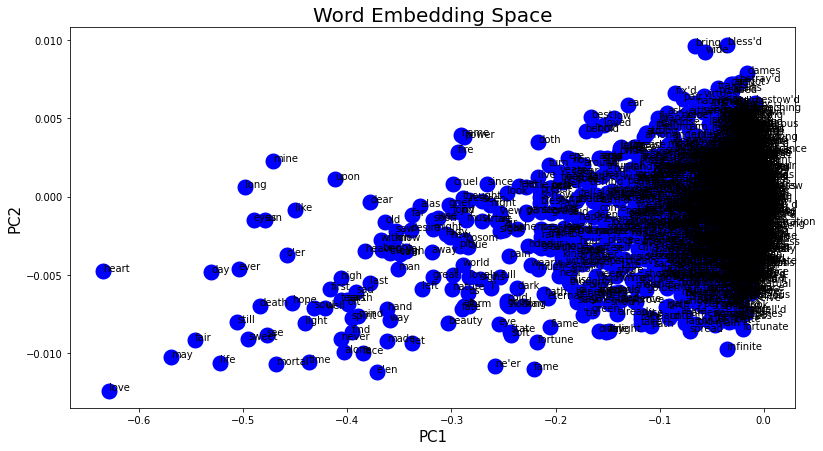

In [196]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(model.wv.vocab)

a
for i, word in enumerate(vocab):
  plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))

Rules of Petrarchan sonnet
- 14 lines
- 8 line subsection / 6 line subsection (seste)
- 8 line --> ABBA ABBA 
- 6 line --> CDE CDE 


In [ ]:
with open('data/poetry/raw.txt', 'r') as rawfp,\
 open('data/poetry/input.txt', 'w') as infp,\
 open('data/poetry/output.txt', 'w') as outfp:
   
   prev_line = ''
   for curr_line in rawfp:
       curr_line = curr_line.strip()
       # poems break at empty lines, so this ensures we train only
       # on lines of the same poem
       if len(prev_line) > 0 and len(curr_line) > 0:       
           infp.write(prev_line + '\n')
           outfp.write(curr_line + '\n')
       prev_line = curr_line